In [1]:
import os
import requests
import numpy as np
import pandas as pd
import vextract.svg
import vextract.filter
import vextract.convert
import svgpathtools as spt
import matplotlib.pyplot as plt

from pathlib import Path

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
# We need to download the article file.
# This article is not open access - a subscription is required.

URL = "https://journals.aps.org/prb/pdf/10.1103/PhysRevB.104.064505"

if not Path('../data/source_data/PhysRevB.104.064505.pdf').exists():
    print('Article file not found.  Attempting to download.')
    response = requests.get(URL)
    try:
        open('../data/source_data/PhysRevB.104.064505.pdf', 'wb').write(response.content)
        print('Article successfully downloaded.')
    except OSError:
        print('Failed to download article.')
else:
    print('Article file found.')

Article file not found.  Attempting to download.
Article successfully downloaded.


In [3]:
# The un-edited paper: PHYSICAL REVIEW B 104, 064505 (2021)
paper_file = '../data/source_data/PhysRevB.104.064505.pdf'

# Location to store the svg version of the relevant page.
svg_page_file = '../data/svg_files/Be22Re_page_3.svg'

# The page number on which the relavant figure is located.
page_number = 3

# Convert page 3 of the paper into an svg file.
os.system(f'pdf2svg {paper_file} {svg_page_file} {page_number}')

# Load the svg file into memory.
# The resulting structure is a tuple of two lists.
# The first is a list of the path objects.
# The second is a list of the corresponding attributes.
svg = (
    # Convert color codes to hex for convenience.
    vextract.convert.hexify(
        # Apply transformation matrix that is inluded in svg attributes.
        vextract.convert.apply_tmatrix(
            # load the file in a tuple of paths and attributes.
            spt.svg2paths(svg_page_file))))

In [4]:
# List the path lengths in decending order to find the longest ones.
# There are 8 paths with length ~ 500.  These correspond to the 8 lines
# plotted in Fig. 3.

paths, attributes = svg

longest_df = pd.DataFrame()

# Compute the length of every path in the file.
longest_df['length'] = [len(path) for path in paths]

# Report the 10 longest paths.
longest_df.length.sort_values(ascending=False).head(10)

342    591
340    528
341    477
339    470
346    465
343    461
345    460
344    451
43      36
83      36
Name: length, dtype: int64

In [5]:
# Create a DataFrame that associates the longest paths with their
# corresponding color

longest_df = longest_df[longest_df.length > 400].copy()
style_strings = [attributes[i]['style'] for i in longest_df.index]
longest_df['color'] = [vextract.svg.style_string_to_dict(style_string)['stroke'] for style_string in style_strings]
longest_df

,length,color
339,470,#000000
340,528,#ff0000
341,477,#0000ff
342,591,#008080
343,461,#ff00ff
344,451,#808000
345,460,#000080
346,465,#800000


/tmp/ipykernel_449667/843739355.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0] + list(longest_df.color), rotation = 90, )


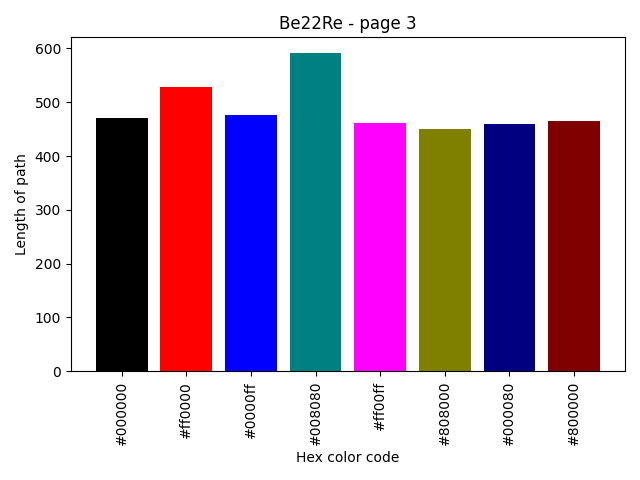

In [6]:
# This is a useful plot for figuring out colors that correspond to
# the longest paths on the page.

fig, ax = plt.subplots()
ax.bar(range(len(longest_df)), longest_df.length, color=longest_df.color)
ax.set_xticklabels([0] + list(longest_df.color), rotation = 90, )
ax.set_xlabel('Hex color code')
ax.set_ylabel('Length of path')
ax.set_title('Be22Re - page 3')
fig.tight_layout()

In [7]:
# Add pressure information to the dataframe.
pressures = [
    '1.2',
    '3.9',
    '7.6',
    '9.8',
    '15',
    '19',
    '25',
    '30'
]

longest_df['pressure'] = pressures

longest_df

,length,color,pressure
339,470,#000000,1.2
340,528,#ff0000,3.9
341,477,#0000ff,7.6
342,591,#008080,9.8
343,461,#ff00ff,15
344,451,#808000,19
345,460,#000080,25
346,465,#800000,30


In [8]:
longest_df['i'] = longest_df.index
longest_df

,length,color,pressure,i
339,470,#000000,1.2,339
340,528,#ff0000,3.9,340
341,477,#0000ff,7.6,341
342,591,#008080,9.8,342
343,461,#ff00ff,15,343
344,451,#808000,19,344
345,460,#000080,25,345
346,465,#800000,30,346


In [9]:
# Create a dictionary where the keys are the pressure
# and the values are dataframes corresponding to the data
# for that pressure.

data_dict = {}
for row in longest_df.to_dict(orient='records'):
    df = pd.DataFrame()
    i = row['i']
    df['x'], df['y'] = vextract.svg.path_starts(paths[i])
    pressure = row['pressure']
    data_dict[pressure] = df

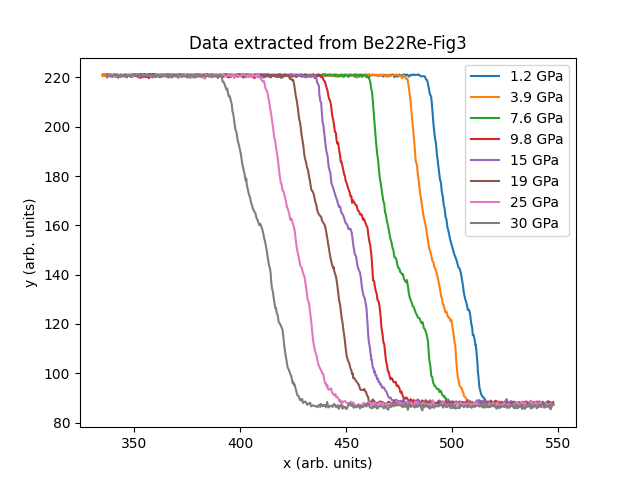

In [10]:
# A plot of the extracted data.
# We still need to properly scale the data.

fig, ax = plt.subplots()
for pressure in pressures:
    df = data_dict[pressure]
    ax.plot(df.x, df.y, label=f'{pressure} GPa')
    
ax.set_xlabel('x (arb. units)')
ax.set_ylabel('y (arb. units)')
ax.set_title('Data extracted from Be22Re-Fig3')
ax.legend()

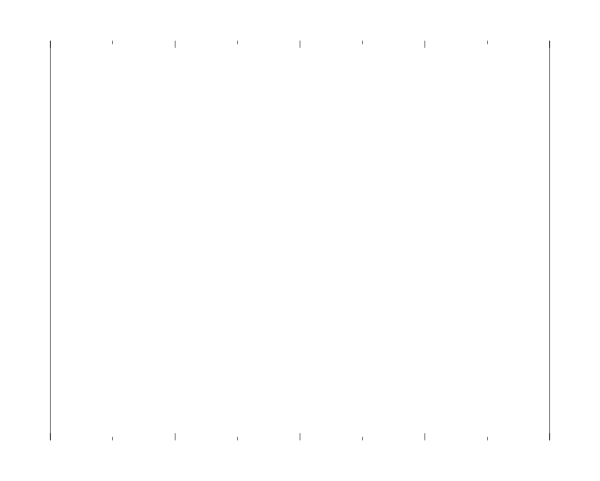

In [11]:
'''
Next, we need to locate the tic marks so that we can scale
the data to the correct units.

In this figure, the tic marks are stored as vertical and horizontal lines.
'''

# The vlines function captures the top and bottom y-axis tic marks,
# but also the left and right axis lines.
vlines = vextract.filter.by_vlines(svg)
vextract.svg.display_svg(vlines)

In [12]:
'''
Here we construct a DataFrame that will help us to figure
out which elements belong to the x-axis tic marks.
'''

vlines_df = pd.DataFrame()
paths, attributes = vlines
vlines_df['length'] = [path.length() for path in paths]
vlines_df['y_start'] = [path.start.imag for path in paths]
vlines_df['x_start'] = [path.start.real for path in paths]

# From the length column, we can see that there are 8 short tic marks
# and 10 long tick marks.
vlines_df.sort_values(['length', 'y_start'])

,length,y_start,x_start
9,1.476562,62.230469,363.558594
10,1.476562,62.230469,416.148438
11,1.476562,62.230469,468.738281
12,1.476562,62.230469,521.328125
0,1.476563,230.531250,363.558594
1,1.476563,230.531250,416.148438
2,1.476563,230.531250,468.738281
3,1.476563,230.531250,521.328125
4,3.019531,230.531250,337.265625
5,3.019531,230.531250,389.855469


In [13]:
# We have two groups of short tic marks (for the upper and lower x-axes)
# and two groups of long tic marks.
# The last DataFrame corresponds to the right and left y-axis lines.
for length, df in vlines_df.groupby('length'):
    print(f'{length = }')
    display(df)

length = 1.4765622500000006


,length,y_start,x_start
9,1.476562,62.230469,363.558594
10,1.476562,62.230469,416.148438
11,1.476562,62.230469,468.738281
12,1.476562,62.230469,521.328125


length = 1.4765629999999987


,length,y_start,x_start
0,1.476563,230.53125,363.558594
1,1.476563,230.53125,416.148438
2,1.476563,230.53125,468.738281
3,1.476563,230.53125,521.328125


length = 3.0195310000000006


,length,y_start,x_start
4,3.019531,230.53125,337.265625
5,3.019531,230.53125,389.855469
6,3.019531,230.53125,442.445312
7,3.019531,230.53125,495.035156
8,3.019531,230.53125,547.628906


length = 3.01953125


,length,y_start,x_start
13,3.019531,62.230469,337.265625
14,3.019531,62.230469,389.855469
15,3.019531,62.230469,442.445312
16,3.019531,62.230469,495.035156
17,3.019531,62.230469,547.628906


length = 168.296875


,length,y_start,x_start
18,168.296875,230.53125,337.265625
19,168.296875,230.53125,547.628906


In [14]:
# We'll use the large (major) tic marks to set the scale for the x-axis.
# That data is contained in the third dataframe shown above.
# The first and last large tic marks correspond to 5 and 9 K, respectively.

groups = vlines_df.groupby('length')
names, dfs = zip(*groups)
x_max = dfs[2]['x_start'].max()
x_min = dfs[2]['x_start'].min()

# These are the svg coordinates of the first and last tic marks.
print(f'{x_max = }, {x_min = }')

x_max = 547.62890625, x_min = 337.265625


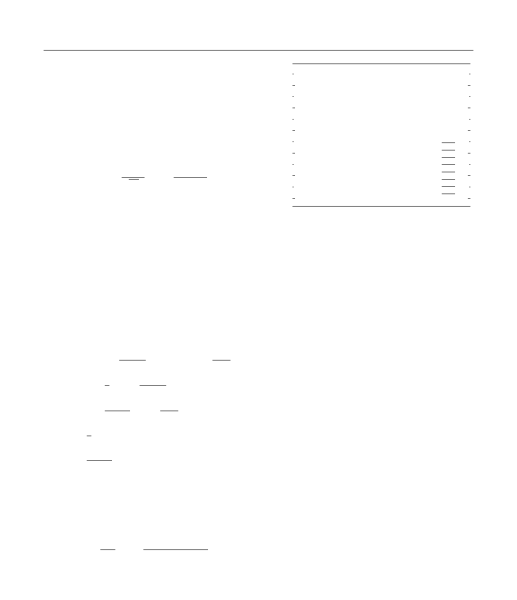

In [15]:
# The hlines function captures the left and right x-axis tic marks,
# but also several other graph elements.
hlines = vextract.filter.by_hlines(svg)
vextract.svg.display_svg(hlines)

In [16]:
'''
Here we construct a DataFrame that will help us to figure
out which elements belong to the y-axis tic marks.
'''

hlines_df = pd.DataFrame()
paths, attributes = hlines
hlines_df['length'] = [path.length() for path in paths]
hlines_df['y_start'] = [path.start.imag for path in paths]
hlines_df['x_start'] = [path.start.real for path in paths]

# From the length column, we can see that there are 8 short tic marks
# and 10 long tick marks.
hlines_df.sort_values(['length', 'x_start'])

,length,y_start,x_start
16,1.472656,207.808594,337.265625
17,1.472656,181.093750,337.265625
18,1.472656,154.378906,337.265625
19,1.472656,127.656250,337.265625
20,1.472656,100.941406,337.265625
21,1.472656,74.226562,337.265625
28,1.472656,207.808594,547.628906
29,1.472656,181.093750,547.628906
30,1.472656,154.378906,547.628906
31,1.472656,127.656250,547.628906


In [17]:
# We have two groups of short tic marks (for the left and right y-axes)
# and two groups of long tic marks.
# Then several DataFrames corresponding to other horizontal line paths.
for length, df in hlines_df.groupby('length'):
    print(f'{length = }')
    display(df)

length = 1.472656000000029


,length,y_start,x_start
16,1.472656,207.808594,337.265625
17,1.472656,181.093750,337.265625
18,1.472656,154.378906,337.265625
19,1.472656,127.656250,337.265625
20,1.472656,100.941406,337.265625
21,1.472656,74.226562,337.265625


length = 1.47265625


,length,y_start,x_start
28,1.472656,207.808594,547.628906
29,1.472656,181.093750,547.628906
30,1.472656,154.378906,547.628906
31,1.472656,127.656250,547.628906
32,1.472656,100.941406,547.628906
33,1.472656,74.226562,547.628906


length = 3.015625


,length,y_start,x_start
22,3.015625,221.199219,337.265625
23,3.015625,194.484375,337.265625
24,3.015625,167.769531,337.265625
25,3.015625,141.050781,337.265625
26,3.015625,114.335938,337.265625
27,3.015625,87.621094,337.265625


length = 3.0156252500000846


,length,y_start,x_start
34,3.015625,221.199219,547.628906
35,3.015625,194.484375,547.628906
36,3.015625,167.769531,547.628906
37,3.015625,141.050781,547.628906
38,3.015625,114.335938,547.628906
39,3.015625,87.621094,547.628906


length = 5.453124750000001


,length,y_start,x_start
6,5.453125,442.628906,115.394531
10,5.453125,502.085938,94.066406


length = 12.0039065


,length,y_start,x_start
2,12.003906,198.605469,143.773438


length = 15.7109375


,length,y_start,x_start
40,15.710938,155.566406,513.757812
41,15.710938,164.195312,513.757812
42,15.710938,172.816406,513.757812
43,15.710938,181.445312,513.757812
44,15.710938,190.070312,513.757812
45,15.710938,198.691406,513.757812
46,15.710938,207.320312,513.757812
47,15.710938,215.941406,513.757812


length = 17.74609375


,length,y_start,x_start
12,17.746094,636.6875,110.113281


length = 21.347656


,length,y_start,x_start
9,21.347656,472.519531,180.90625


length = 21.34765675


,length,y_start,x_start
5,21.347657,412.507812,242.644531


length = 27.054687750000028


,length,y_start,x_start
1,27.054688,196.300781,135.347656


length = 29.84374975


,length,y_start,x_start
8,29.84375,472.519531,115.394531
11,29.84375,531.109375,94.066406


length = 31.457031


,length,y_start,x_start
7,31.457031,442.628906,156.515625


length = 31.45703125


,length,y_start,x_start
4,31.457031,412.507812,132.386719


length = 39.41015650000003


,length,y_start,x_start
3,39.410157,196.300781,196.835938


length = 76.4374995


,length,y_start,x_start
13,76.4375,636.6875,161.007812


length = 210.36328100000003


,length,y_start,x_start
14,210.363281,230.531250,337.265625
15,210.363281,62.230469,337.265625


length = 508.09375


,length,y_start,x_start
0,508.09375,46.085938,43.0625


In [18]:
# We'll use the large (major) tic marks to set the scale for the y-axis.
# That data is contained in the third dataframe shown above.
# The first and last large tic marks correspond to normalized resistivities
# of 0 and 1, respectively.

groups = hlines_df.groupby('length')
names, dfs = zip(*groups)
y_max = dfs[2]['y_start'].max()
y_min = dfs[2]['y_start'].min()

# These are the svg coordinates of the first and last tic marks.
print(f'{y_max = }, {y_min = }')

y_max = 221.19921875, y_min = 87.62109375


In [19]:
# Now we have the scale factors for both the x and y axes, so we can
# add columns to our data sets to represent properly scaled data.

for pressure in data_dict:
    df = data_dict[pressure]
    df['rho_n'] = df.y.apply(lambda rho_arb: vextract.svg.transform_coord(y_min, y_max, 1.0, 0, rho_arb))
    df['Temp'] = df.x.apply(lambda Temp_arb: vextract.svg.transform_coord(x_min, x_max, 5, 9, Temp_arb))

In [20]:
# Here is an example of how our data looks for the 1.2 GPa measurement.
display(data_dict['1.2'])

,x,y,rho_n,Temp
0,337.195312,221.199219,0.000000,4.998663
1,337.332031,220.570313,0.004708,5.001263
2,337.546875,221.199219,0.000000,5.005348
3,337.824219,220.851563,0.002603,5.010622
4,338.179688,221.062500,0.001024,5.017381
...,...,...,...,...
465,544.750000,87.550781,1.000526,8.945258
466,545.382813,87.691406,0.999474,8.957291
467,546.156250,87.691406,0.999474,8.971998
468,546.851563,87.757813,0.998976,8.985219


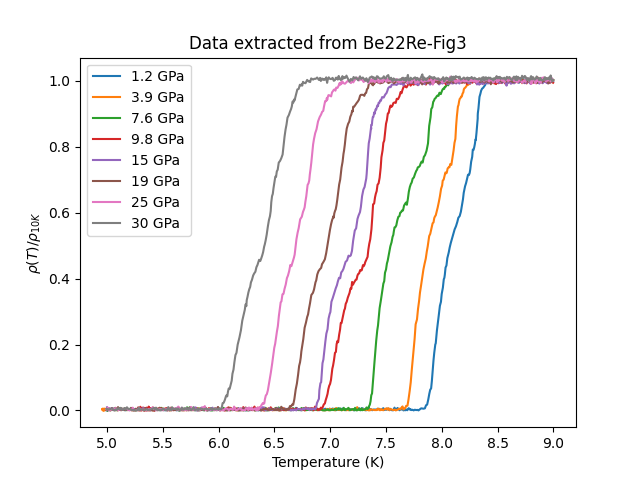

In [21]:
# Extraction is complete.
# Now let's plot all the data.

fig, ax = plt.subplots()
for pressure in data_dict:
    df = data_dict[pressure]
    ax.plot(df.Temp, df.rho_n, label=f'{pressure} GPa')
    
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r"$\rho (T) / \rho _{10 K}$")
ax.set_title('Data extracted from Be22Re-Fig3')
ax.legend()

In [22]:
# Now export the 15 GPa data for inclusion in publication plots.

df = data_dict['15']
df.to_csv('../data/extracted_data/Be22Re-Fig3/15_GPa.csv', index=False)